# Case Study 5: Imputation

#### Steven Hayden, Kevin Mendonsa, Joe Schueder, Nicole Wittlin

## Introduction

Blah blah blah intro

In [42]:
import warnings
import itertools
import os
import numpy as np
import matplotlib.pyplot as plt
#warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from ml_metrics import rmse


## Exploratory Data Analysis 

The data we are using for this analysis is the Boston Housing dataset, which was compiled in the late 1970s to explore if people would pay more for cleaner air. It is based on 1970 census tract data from the Boston Standard Metropolitan Statistical Area and represents key characteristics of approximately **{What -- houses? tracts?}**. Data was downloaded from sklearn's standard datasets. 

The data has 13 numeric or categorical variables that describe a variety of characteristics related to homes: community details related crime rate, proximity to businesses, highways, and key employment centers, student-teacher ratio, population demographics; and details about the property related to zoning, age, occupancy, size, proximity to the Charles River, taxes, and concentration of nitric oxides. The target prediction variable is the Median Value of each house. The data only represents owner-occupied properties. 

A data dictionary can be found below, which summarizes the variable definitions. 

A few important notes about the dataset:
- House prices in thousands of dollars; the Census Service censored the data and capped home prices at $50K.
- No missing data in dataset.
- Correlated variables
    - Positive Correlations
        - Tax/Rad (0.91)
        - Indus/Nox (0.76)
        - Nox/Age (0.73)
        - Indus/Tax (0.72)
    - Negative Correlations
        - Nox/Dis (-0.77)
        - Age/Dis (-0.75)
        - LSTAT / MEDV (-0.74)

Add the Pandas Profiling piece
Expand on the variables -- 

We conducted limited exploratory data analysis as the objective of the work is to explore how missing data and imputation strategies can impact model results.

In [43]:
from sklearn.datasets import load_boston
boston = load_boston()

In [44]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [45]:
#https://www.engineeringbigdata.com/boston-dataset-scikit-learn-machine-learning-in-python/
bostondf = pd.DataFrame(boston.data)
#bostondf.head()
bostondf.columns = boston.feature_names
bostondf['MEDV'] = boston.target
bostondf.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [46]:
bostondf.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [47]:
bostondf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [48]:
from sklearn.datasets import load_boston
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

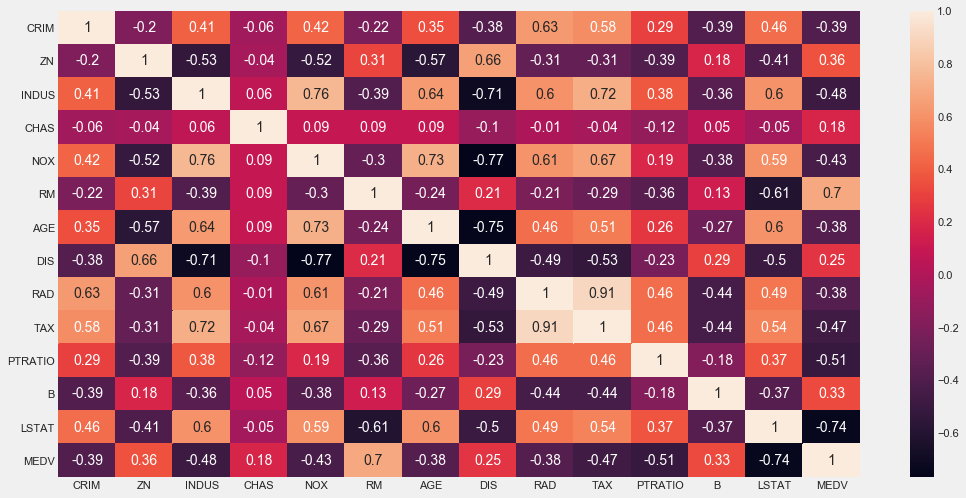

In [49]:
correlation_matrix = bostondf.corr().round(2)
plt.figure(figsize = (16,8))
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

In [50]:
bostondf.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

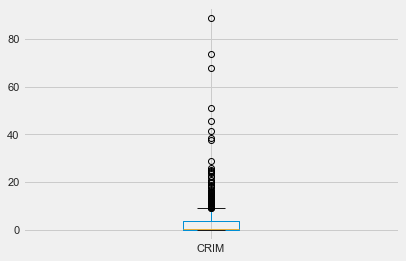

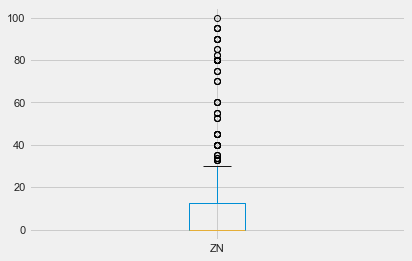

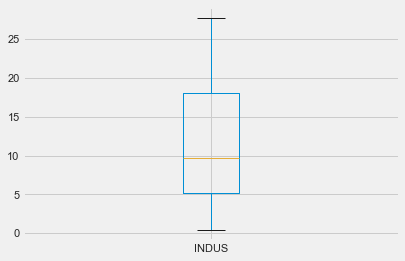

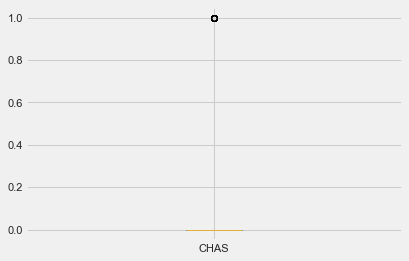

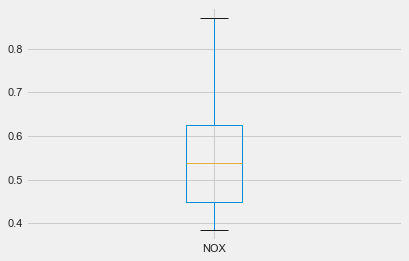

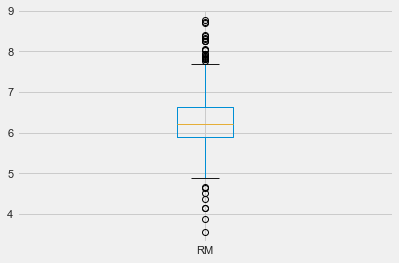

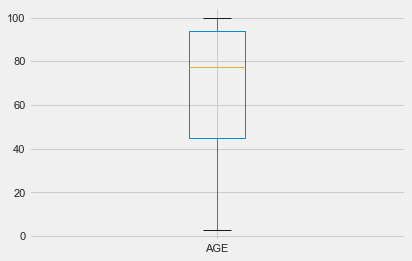

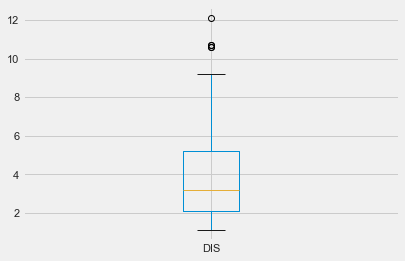

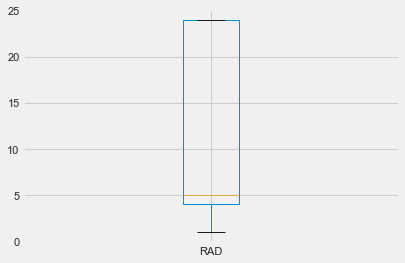

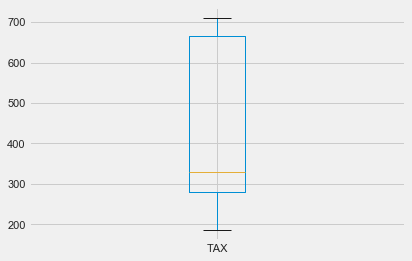

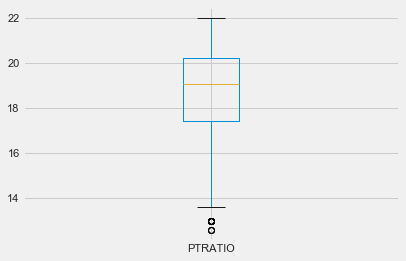

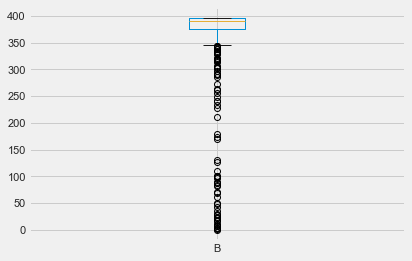

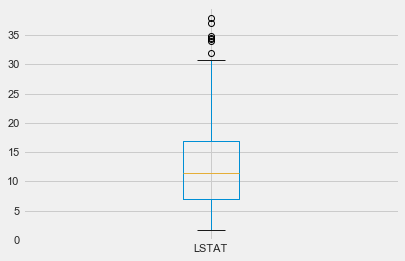

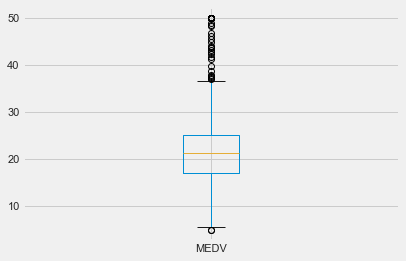

In [51]:
import matplotlib.pyplot as plt

for column in bostondf:
    plt.figure()
    bostondf.boxplot([column])

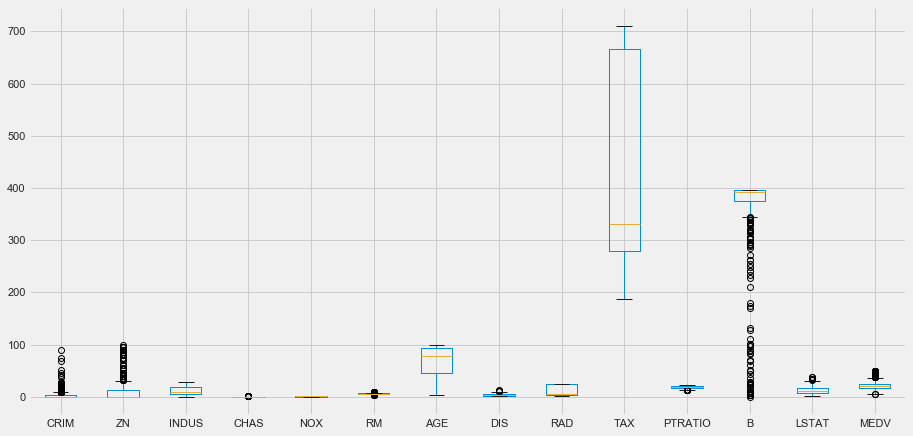

In [52]:
bostondf.plot(kind='box', figsize=(14,7))
plt.show()

C:\Users\shayden\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernels.py:125: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
C:\Users\shayden\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernels.py:125: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
C:\Users\shayden\Anaconda3\lib\site-packages\statsmodels\nonparametric\_kernel_base.py:514: RuntimeWarning: invalid value encountered in true_divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
C:\Users\shayden\Anaconda3\lib\site-packages\matplotlib\contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\shayden\Anaconda3\lib\site-packages\matplotlib\contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
C:\Users\shayden\Anaconda3\lib\site-package

C:\Users\shayden\Anaconda3\lib\site-packages\matplotlib\contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\shayden\Anaconda3\lib\site-packages\matplotlib\contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
C:\Users\shayden\Anaconda3\lib\site-packages\matplotlib\contour.py:1169: RuntimeWarning: invalid value encountered in less
  under = np.nonzero(lev < self.zmin)[0]
C:\Users\shayden\Anaconda3\lib\site-packages\matplotlib\contour.py:1171: RuntimeWarning: invalid value encountered in greater
  over = np.nonzero(lev > self.zmax)[0]
C:\Users\shayden\Anaconda3\lib\site-packages\matplotlib\contour.py:1200: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
C:\Users\shayden\Anaconda3\lib\site-packages\matplotlib\contour.py:1200: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin)

Text(0.5, 1, 'Pair Plots for Boston Housing')

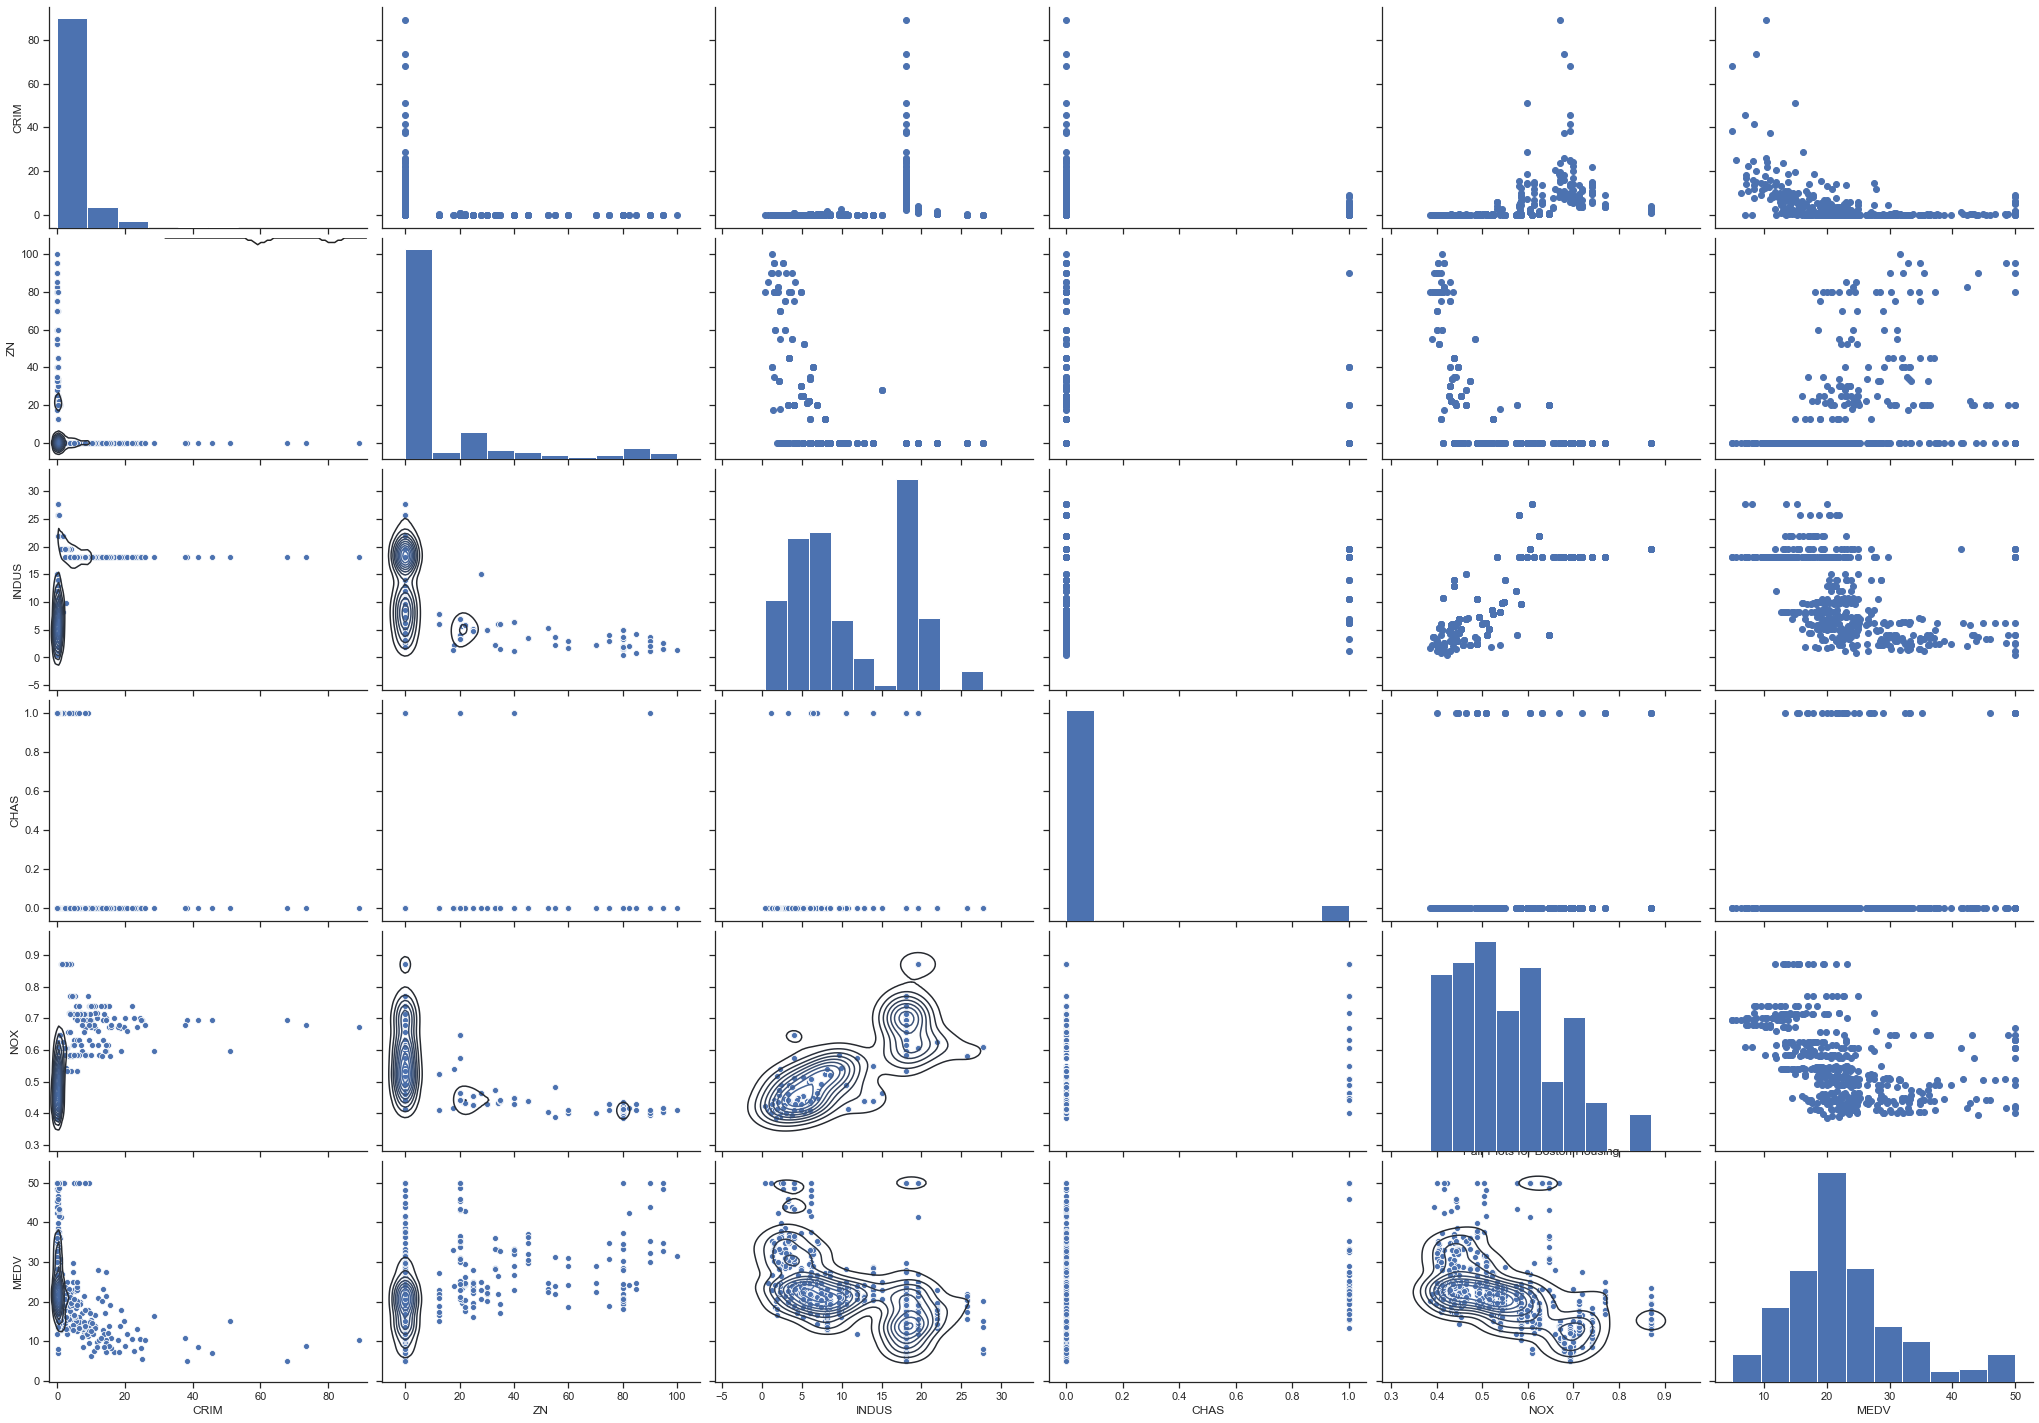

In [53]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
g = sns.pairplot(bostondf, vars=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',  'MEDV'], height=3.27, aspect=4.7/3.27)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)
#iris = sns.load_dataset("iris")8.7/8.27)
plt.title("Pair Plots for Boston Housing")

Text(0.5, 1, 'Pair Plots for Boston Housing')

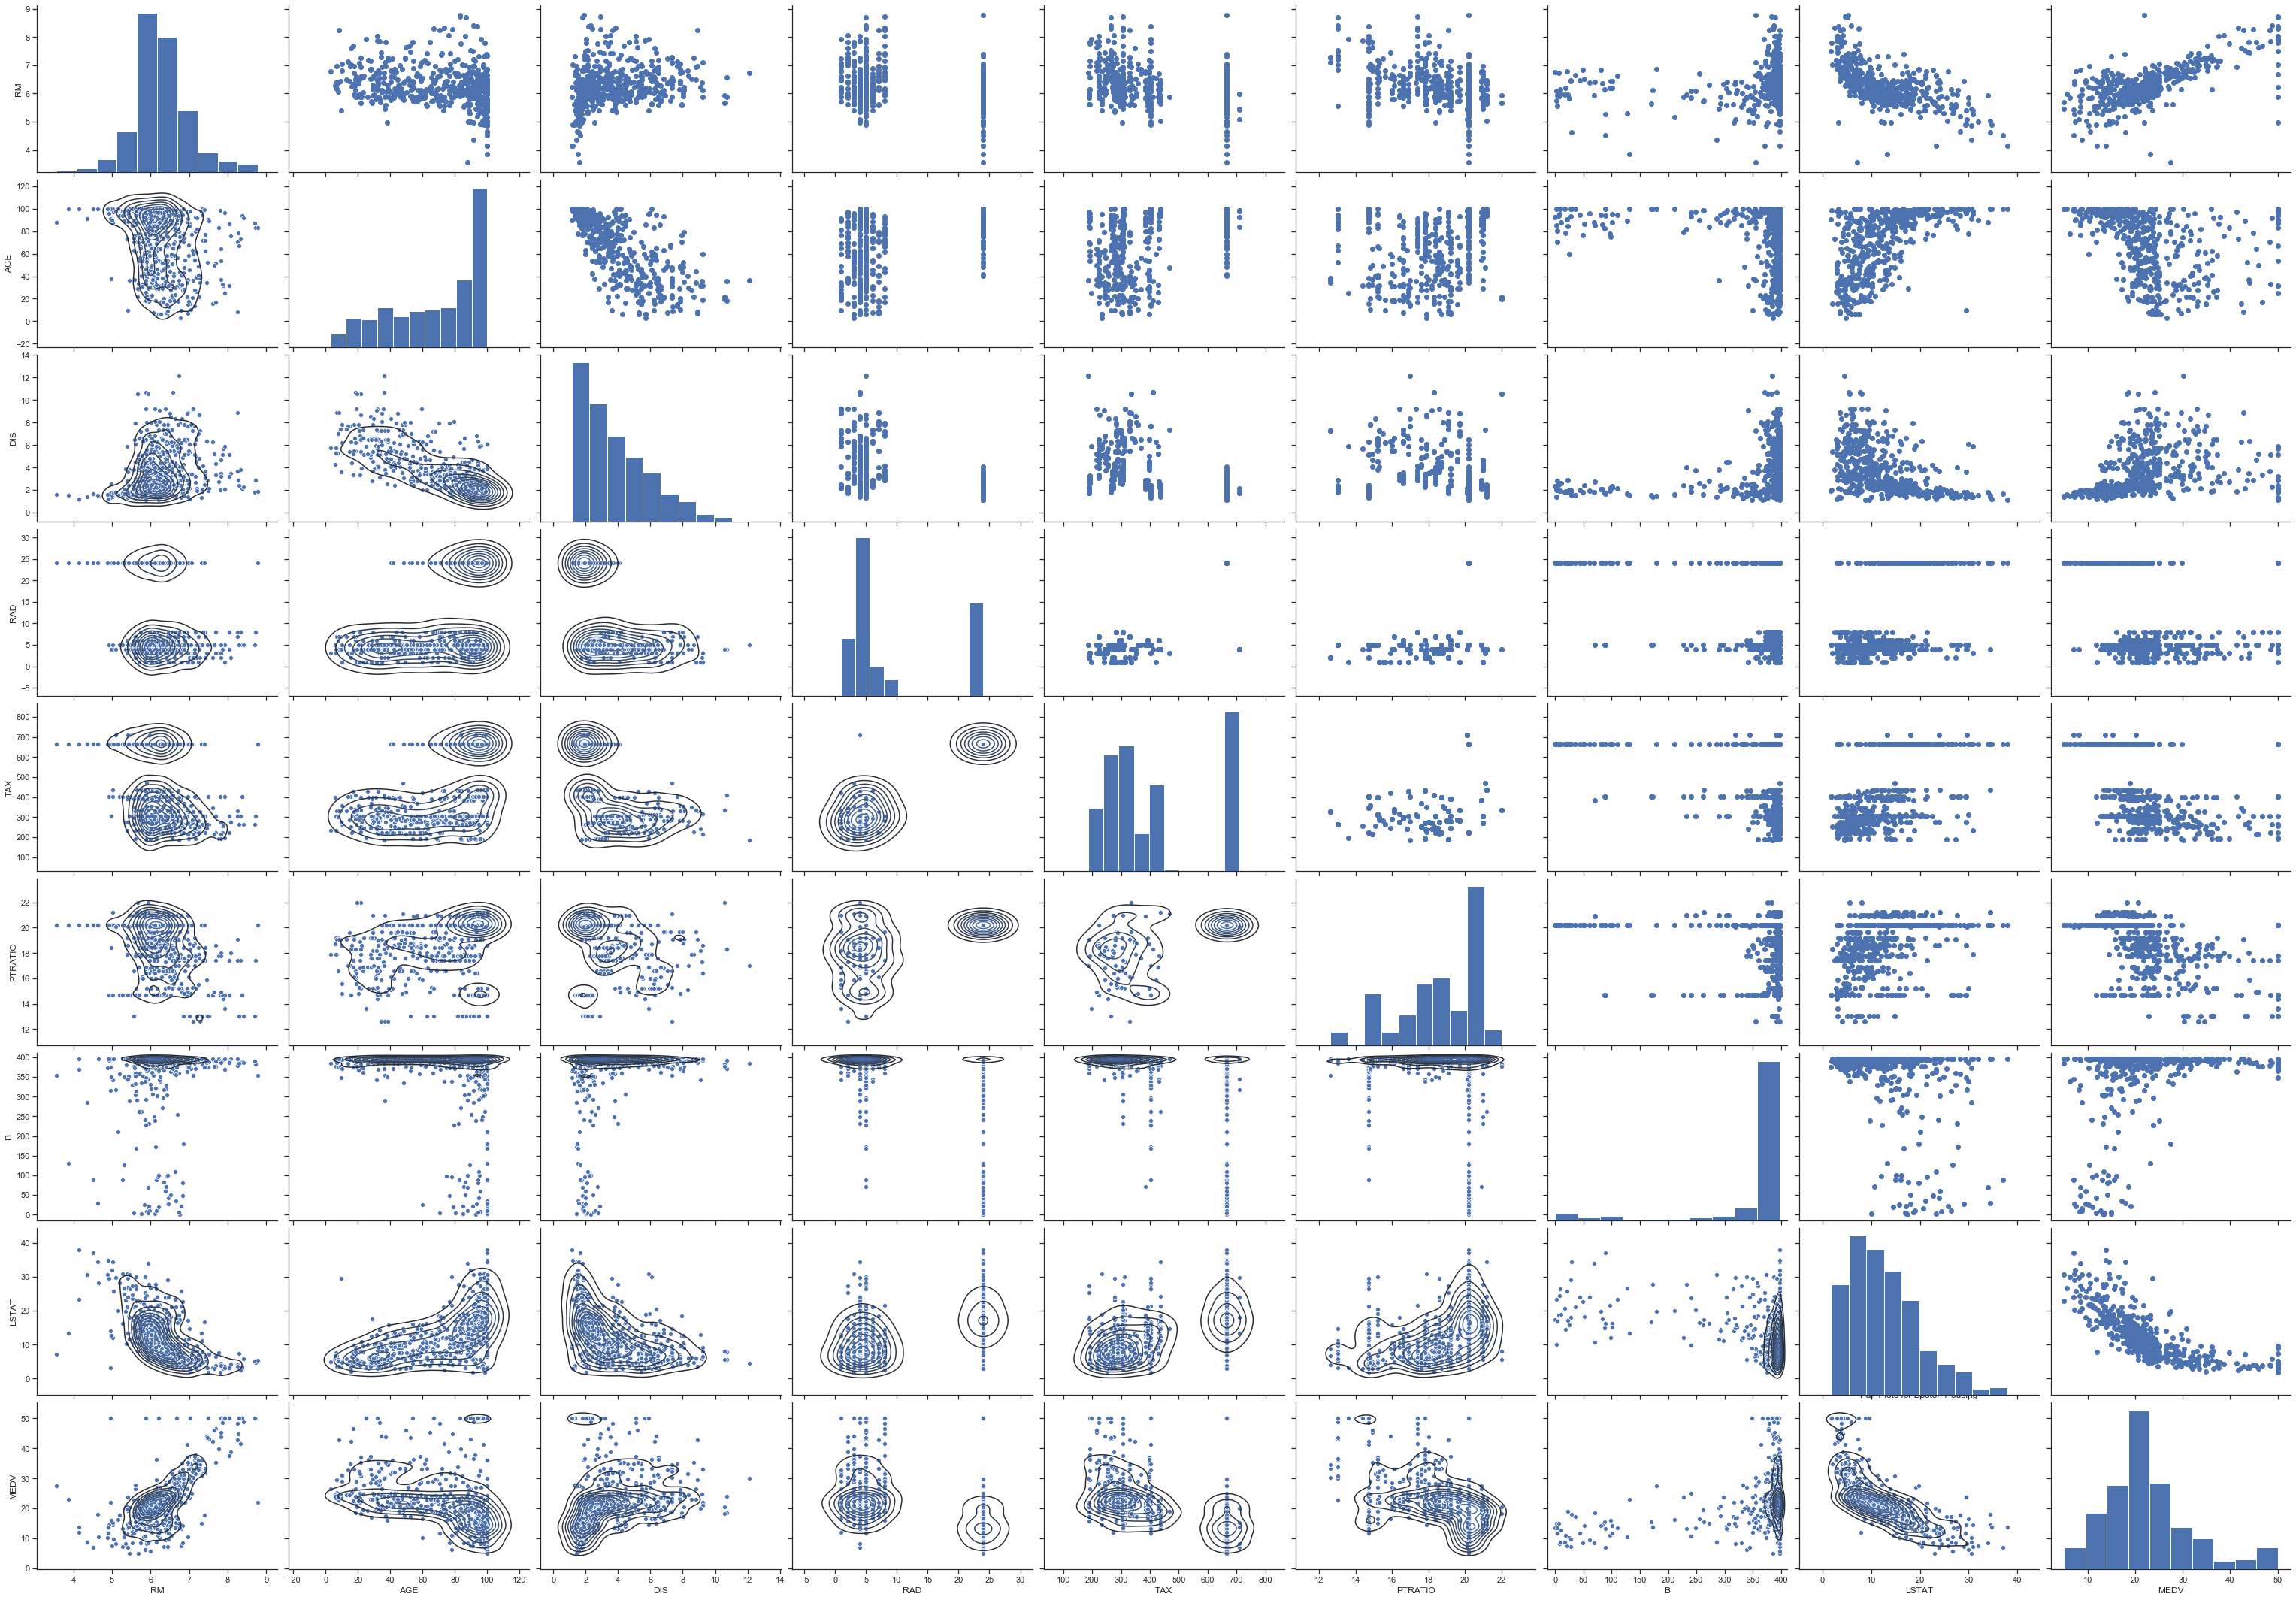

In [54]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
g = sns.pairplot(bostondf, vars=['RM', 'AGE', 'DIS', 'RAD', 'TAX','PTRATIO', 'B', 'LSTAT',  'MEDV'], height=3.27, aspect=4.7/3.27)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)
#iris = sns.load_dataset("iris")8.7/8.27)
plt.title("Pair Plots for Boston Housing")


## Imputation Study 

### Baseline Model

Fit a linear regression odel to the data, did not need to do Cross-Validation as we are simply exploring the change in results. Training set of 70% of data (354 records); test set of 30% (152 records)

Loss:
- MAE: 3.605
- MSE:  24.099
- RMSE:  4.909
- R2:  0.705

Goodness of Fit:


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average weekly positive cases in the test set within **1424.16 of the real flu cases.** This will be closer to the units of measure. We believe this is this error seems acceptable give that this is across the entire population of the country. Give that some weeks have 25,000+ cases a week, the apprimately 1,500 error spread across the country should have minimal impact for preparation.


In [55]:
# Create training and testing sets (cross-validation not needed)
train_set = bostondf.sample(frac=0.7, random_state=100)
test_set = bostondf[~bostondf.isin(train_set)].dropna()
print(train_set.shape[0])
print(test_set.shape[0])

354
152


In [56]:
# Get the training and testing row indices for later use
train_index = train_set.index.values.astype(int)
test_index = test_set.index.values.astype(int)

In [57]:
# Demonstration of using the row indices above to select consistent records
bostondf.iloc[train_index].head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
198,0.03768,80.0,1.52,0.0,0.404,7.274,38.3,7.3090,2.0,329.0,12.6,392.20,6.62,34.6
229,0.44178,0.0,6.20,0.0,0.504,6.552,21.4,3.3751,8.0,307.0,17.4,380.34,3.76,31.5
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
31,1.35472,0.0,8.14,0.0,0.538,6.072,100.0,4.1750,4.0,307.0,21.0,376.73,13.04,14.5
315,0.25356,0.0,9.90,0.0,0.544,5.705,77.7,3.9450,4.0,304.0,18.4,396.42,11.50,16.2


In [58]:
# Converting the training and testing datasets back to matrix-formats
X_train = train_set.iloc[:, :-1].values # returns the data; excluding the target
Y_train = train_set.iloc[:, -1].values # returns the target-only
X_test = test_set.iloc[:, :-1].values # ""
Y_test = test_set.iloc[:, -1].values # ""

In [59]:
Y_train

array([34.6, 31.5, 20.6, 14.5, 16.2, 22.3, 22.8, 24.4, 19.8, 16.7, 23.2,
       15.1, 21. , 18.9, 48.5, 24.1, 22.5, 16.1, 30.3, 50. , 33.8, 10.4,
       20.4, 14.2, 10.5, 12.7, 24.5, 16.7, 20.1, 17.1, 18.4, 24.3, 50. ,
       23.8, 30.7, 33.4, 15. , 10.9, 19.1, 21. , 22.9, 22.4, 19. , 19.3,
       27. , 27.1, 19.1, 15.4, 19.1, 13.5, 20.9, 19.3, 20.5, 26.2, 12. ,
       19.7, 29.6, 34.9,  8.3, 21.2, 14.5, 27.5, 19.4, 32.7, 21.1, 28.1,
       17.4, 30.1, 21.4, 20.9, 10.9, 21.7,  8.8, 15.2, 26.6,  8.7, 24.7,
       38.7,  6.3, 22.6, 43.8, 50. , 14.5, 11.7, 12.5, 13.6, 21.5, 19.1,
        9.5, 17.2, 29.8, 22.6, 21.6, 22.2, 27.1, 17. , 22. , 50. ,  7.2,
       50. , 14. , 11. , 10.2, 22.1, 41.3, 17.6, 24.7,  8.5,  8.1, 26.4,
       23. , 35.1, 35.4, 12.8, 24. , 20.2, 29.4, 16. , 50. ,  8.5, 14.9,
       13.8, 21.8, 23.1, 20.1, 13.4, 15.3, 20. , 20. , 19.7, 22.8, 18.2,
       23.3, 18.4, 23. , 50. , 23.1, 23.3, 21.4, 21.4, 13.1,  7. , 14.3,
       31.2, 30.5, 19.6, 50. , 24.4, 18.8, 29.9, 12

In [60]:
# Fit a linear regression to the training data
reg = LinearRegression(normalize=True).fit(X_train, Y_train)
print(reg.score(X_train, Y_train))
print(reg.coef_)
print(reg.intercept_)
print(reg.get_params())

0.7478284701218886
[-1.35456753e-01  5.48606010e-02  5.46611167e-02  3.57648807e+00
 -2.01163242e+01  3.96567027e+00  1.33685712e-02 -1.48716658e+00
  2.99295349e-01 -9.83868843e-03 -9.45023886e-01  6.45207267e-03
 -5.77572297e-01]
36.079347688282304
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': True}


In [61]:
# Show Coef of the variables 
for x,y in zip(bostondf.columns, reg.coef_):
    print(x," : ",y)

CRIM  :  -0.13545675283333689
ZN  :  0.05486060103359965
INDUS  :  0.05466111666902427
CHAS  :  3.576488065984514
NOX  :  -20.11632424763777
RM  :  3.9656702708586273
AGE  :  0.013368571236074277
DIS  :  -1.4871665788179078
RAD  :  0.29929534944621167
TAX  :  -0.009838688425542912
PTRATIO  :  -0.9450238858515401
B  :  0.0064520726706565655
LSTAT  :  -0.5775722969727087


In [62]:
# Find the variable with the largest "normalized" coefficient value
# print('The abs(max) coef-value is {}'.format(max(reg.coef_))) # Positive Max
print('The abs(max) coef-value is {}'.format(max(reg.coef_, key=abs))) # ABS Max
#max_var = max(reg.coef_) # Positive Max
max_var = max(reg.coef_, key=abs) # ABS Max
var_index = reg.coef_.tolist().index(max_var)
print('The variable associated with this coef-value is {}'.format(boston.feature_names[var_index]))

The abs(max) coef-value is -20.11632424763777
The variable associated with this coef-value is NOX


**SHOULD THE ABOVE BE absolute value, or true positive value. 

In [63]:
Y_pred = reg.predict(X_test)

orig_mae = mean_absolute_error(Y_test,Y_pred)
orig_mse = mean_squared_error(Y_test,Y_pred)
orig_rmse_val = rmse(Y_test,Y_pred)
orig_r2 = r2_score(Y_test,Y_pred)
print("MAE: %.3f"%orig_mae)
print("MSE:  %.3f"%orig_mse)
print("RMSE:  %.3f"%orig_rmse_val)
print("R2:  %.3f"%orig_r2)

MAE: 3.605
MSE:  24.099
RMSE:  4.909
R2:  0.705


In [64]:
res_frame = pd.DataFrame({'Imputation %':0,
                   'imputation':'none',
                   'mae': orig_mae, 
                   'mse': orig_mse, 
                   'rmse':orig_rmse_val, 
                   'R2':orig_r2,
                   'mae_diff':np.nan,
                   'mse_diff':np.nan,
                   'rmse_diff':np.nan,
                   'R2_diff':np.nan
                         }, index=[0])


The scatter plot below shows the prediction plotted against the actuals of the house prices. The black line represents a perfect prediction.  You can see that there is a good distribution above and below the line. Towards the top end of prices there does seem to be some biased where the model does predict lower than the actuals. If this exercise was about getting the highest accuracy instead of measuring impact of missing data, it may warrant a look into this bias. 

Text(0.5, 1.0, 'Actual Prices vs Predicted prices')

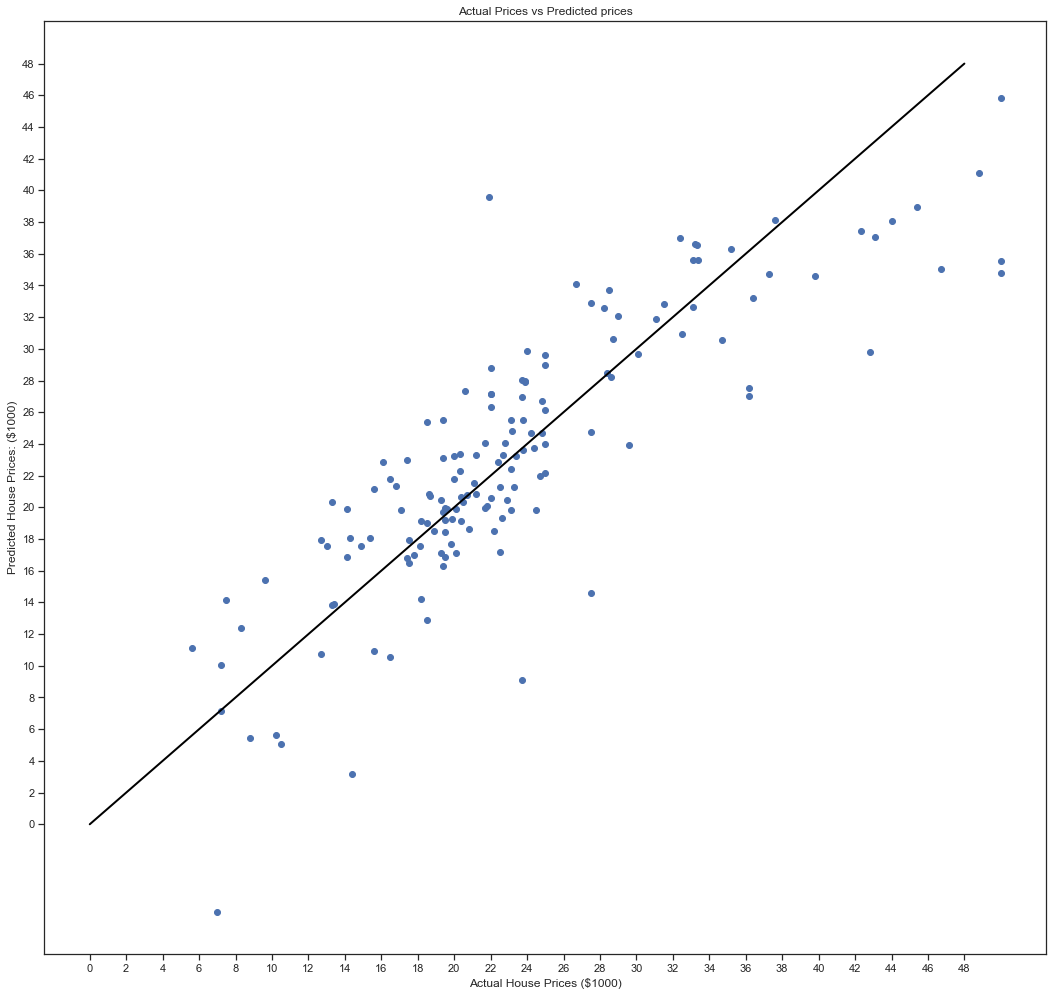

In [65]:
plt.figure(figsize = (16,16))
plt.scatter(Y_test, Y_pred)
plt.plot([0, 48], [0, 48], color = 'black', linewidth = 2)
plt.xlabel("Actual House Prices ($1000)")
plt.ylabel("Predicted House Prices: ($1000)")
plt.xticks(range(0, int(max(Y_test)),2))
plt.yticks(range(0, int(max(Y_test)),2))

plt.title("Actual Prices vs Predicted prices")

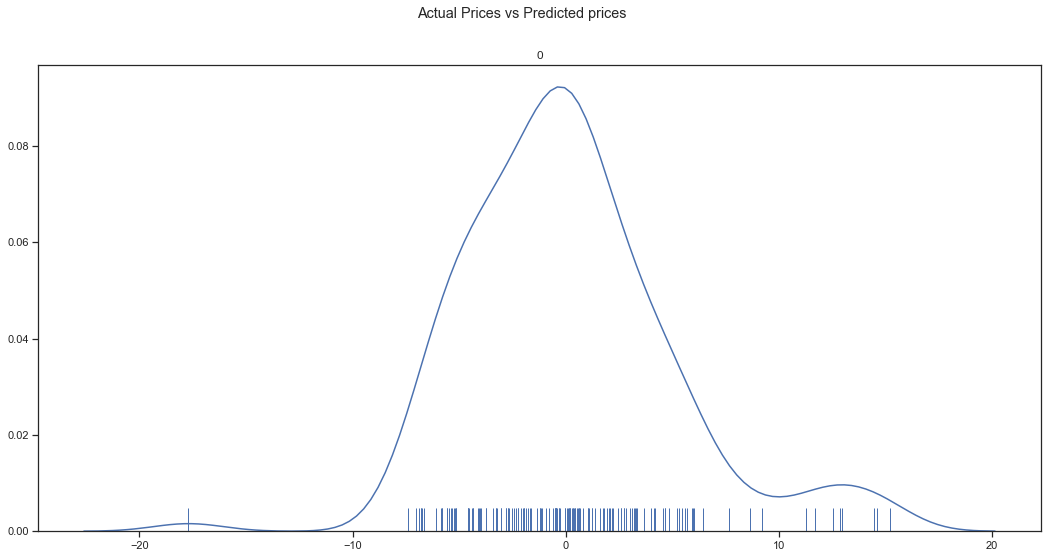

In [66]:
res0 = Y_test-Y_pred
plt.figure(figsize = (16,8))
plt.title(0)
plt.suptitle("Actual Prices vs Predicted prices")
sns.distplot((Y_test-Y_pred),bins=50, hist=False, rug=True);

### Imputation Analysis: Round 1 - Missing at Random

**Here we can randomly sample the full dataset and replace a single column's values**

Step 2: (repeat for each percentage value below) Select 1%, 5% 10%, 20%, 33%, and 50% of your data in a single column [hold that column selection constant throughout all iterations] (Completely at random), replace the original value with a NaN (i.e., “not a number” – ex., np.nan) and then perform an imputation for the missing values.

Question 2: In each case [1%, 5%, 10%, 20%, 33%, 50%] perform a fit with the imputed data and compare the loss and goodness of fit to your baseline. [Note: you should have (6) models to compare against your baseline at this point.]

**Missing Completely at Random (MCAR)** probability of missing values in a variable is same for all samples, no effect of MCAR on inferences made by a model trained on such data

**Missing at Random (MAR)** probability of missing values, at random, in a variable depends only on the available information in other predictors, handled by using information in other predictors to build a model and impute value for the missing entry. 

**Imputation Strategy**

**How to Compensate for Missing Values**
- Do Nothing
- Remove
- Impute using zero, mean, median, mode
- Impute using a randomly selected value
- Impute using a model (often K-NN)
    - Model-based imputation with uncertainty
    - Model-based progressive imputation 
- Others (Stochastic Regression Imputation, Multiple Imputation, Datawig (deep learning), Hot-Deck Imputation, Extrapolation, Interpolation, Listwise Deletion)

** We decided what column to hold constant, yes?

In [67]:
def imputation_defintion(frac):
    # Here we randomly sample the full dataset and replace a single column's values  
    in_sample = bostondf.sample(frac=frac, random_state=99)
    in_sample.shape
    out_sample = bostondf[~bostondf.isin(in_sample)].dropna()
    out_sample.shape

    print(out_sample.shape[0] + in_sample.shape[0])
    print(bostondf.shape[0])

    in_sample.head()

    ## Choose a variable to replace   
    in_sample['NOX'] = np.nan
    #in_sample['RM'] = np.nan
    in_sample.head()

    out_sample['NOX'].median()
    #out_sample['RM'].median()

    #in_sample['NOX'] = in_sample['NOX'].fillna(out_sample['NOX'].median())
    #in_sample['NOX'] = in_sample['NOX'].fillna(1)
 
    #**Choose an imputation method**   
    in_sample['NOX'] = in_sample['NOX'].fillna(out_sample['NOX'].median())
        #in_sample['RM'] = in_sample['RM'].fillna(out_sample['RM'].median())
    in_sample.head()
    #**Rejoin the imputed and original datasets**
    imputed_data = pd.concat([in_sample, out_sample])
    imputed_data = imputed_data.sort_index()
    imputed_data.head()

    #**Use the same training and testing indices to fit the model**    
    train_set = imputed_data.iloc[train_index]
    test_set = imputed_data.iloc[test_index]
    train_set.head()
    
    X_train = train_set.iloc[:, :-1].values
    Y_train = train_set.iloc[:, -1].values
    X_test = test_set.iloc[:, :-1].values
    Y_test = test_set.iloc[:, -1].values

    #**Fit a new model to the imputed dataset**
    reg2 = LinearRegression().fit(X_train, Y_train)
    print(reg2.score(X_train, Y_train))
    print(reg2.coef_)
    print(reg2.intercept_)
    print(reg2.get_params())

    Y_pred = reg2.predict(X_test)

    mae = mean_absolute_error(Y_test,Y_pred)
    mse = mean_squared_error(Y_test,Y_pred)
    rmse_val = rmse(Y_test,Y_pred)
    r2 = r2_score(Y_test,Y_pred)
    print("MAE: %.3f"%mae)
    print("MSE:  %.3f"%mse)
    print("RMSE:  %.3f"%rmse_val)
    print("R2:  %.3f"%r2)
    plt.figure(figsize = (16,8))
    plt.title(frac)
    plt.suptitle("Actual Prices vs Predicted prices")
    sns.distplot((Y_test-Y_pred),bins=50);
    
    temp_frame = pd.DataFrame({'Imputation %':frac,
                   'imputation':'MAR',
                   'mae': mae, 
                   'mse': mse, 
                   'rmse':rmse_val,
                   'R2':r2,
                   'mae_diff':mae-orig_mae,
                   'mse_diff':mse-orig_mse,
                   'rmse_diff':rmse_val-orig_rmse_val,
                   'R2_diff':r2-orig_r2
                   }, index=[0])
    return temp_frame, Y_test-Y_pred

#### Subsequent rounds of imputation

506
506
0.7473400313643322
[-1.35155795e-01  5.52707124e-02  5.04512207e-02  3.57426168e+00
 -1.95531963e+01  3.97717969e+00  1.16279357e-02 -1.49119813e+00
  2.97443527e-01 -9.82195776e-03 -9.38304171e-01  6.47444250e-03
 -5.78432444e-01]
35.7783259183436
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
MAE: 3.612
MSE:  24.082
RMSE:  4.907
R2:  0.705
506
506
0.7476551630095785
[-1.31860849e-01  5.40504320e-02  4.60203744e-02  3.38658644e+00
 -1.88916248e+01  4.07601298e+00  1.06991810e-02 -1.46423483e+00
  2.89255172e-01 -1.00158356e-02 -9.16770518e-01  5.76864996e-03
 -5.84158646e-01]
34.85741983973343
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
MAE: 3.659
MSE:  24.641
RMSE:  4.964
R2:  0.698
506
506
0.7437202924848851
[-1.27056590e-01  5.51392493e-02  2.91485534e-02  3.53112136e+00
 -1.56113087e+01  4.08910005e+00  7.38118179e-03 -1.41736201e+00
  2.72886172e-01 -9.99168622e-03 -8.68825044e-01  6.40288169e-03
 -5.88525597e-0

,Imputation %,imputation,mae,mse,rmse,R2,mae_diff,mse_diff,rmse_diff,R2_diff
0,0.00,none,3.604571,24.098505,4.909023,0.704940,NaN,NaN,NaN,NaN
0,0.01,MAR,3.611796,24.081772,4.907318,0.705145,0.007225,-0.016733,-0.001705,0.000205
0,0.05,MAR,3.658619,24.641265,4.963997,0.698294,0.054048,0.542761,0.054974,-0.006646
0,0.10,MAR,3.657249,24.979995,4.997999,0.694147,0.052677,0.881490,0.088976,-0.010793
0,0.20,MAR,3.557174,24.042646,4.903330,0.705624,-0.047397,-0.055858,-0.005693,0.000684
0,0.33,MAR,3.564066,24.041875,4.903251,0.705633,-0.040505,-0.056630,-0.005771,0.000693
0,0.50,MAR,3.619510,24.446555,4.944346,0.700678,0.014939,0.348050,0.035323,-0.004261


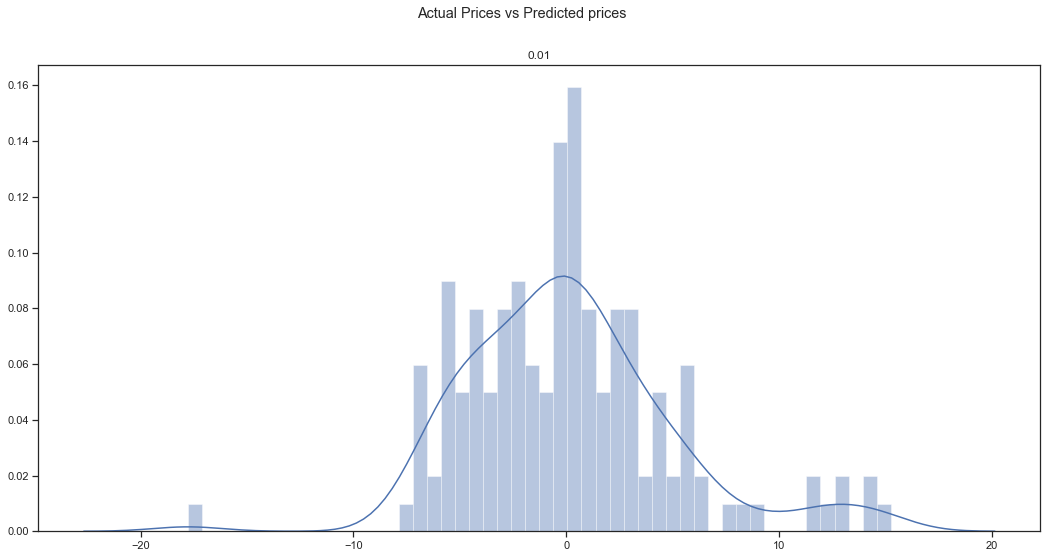

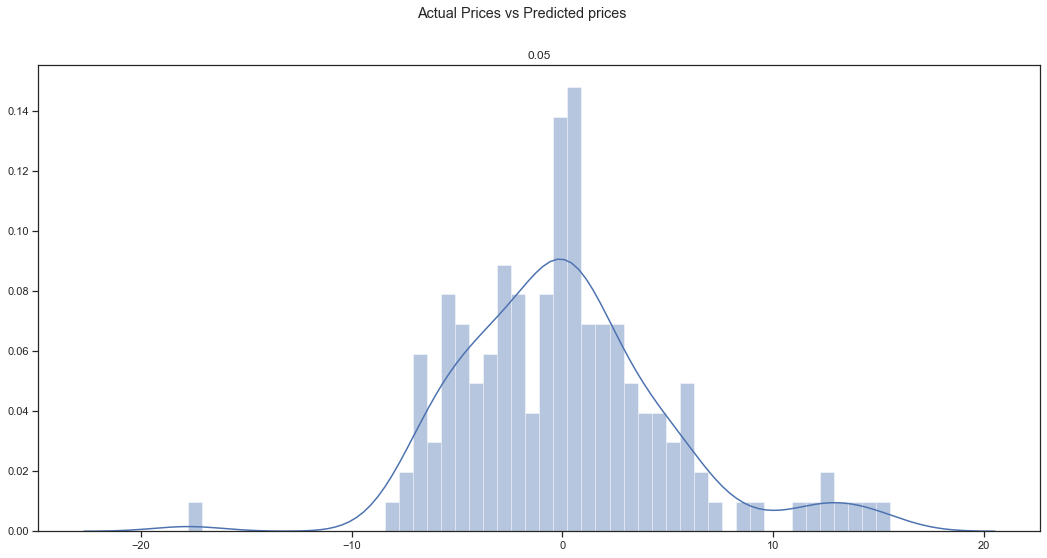

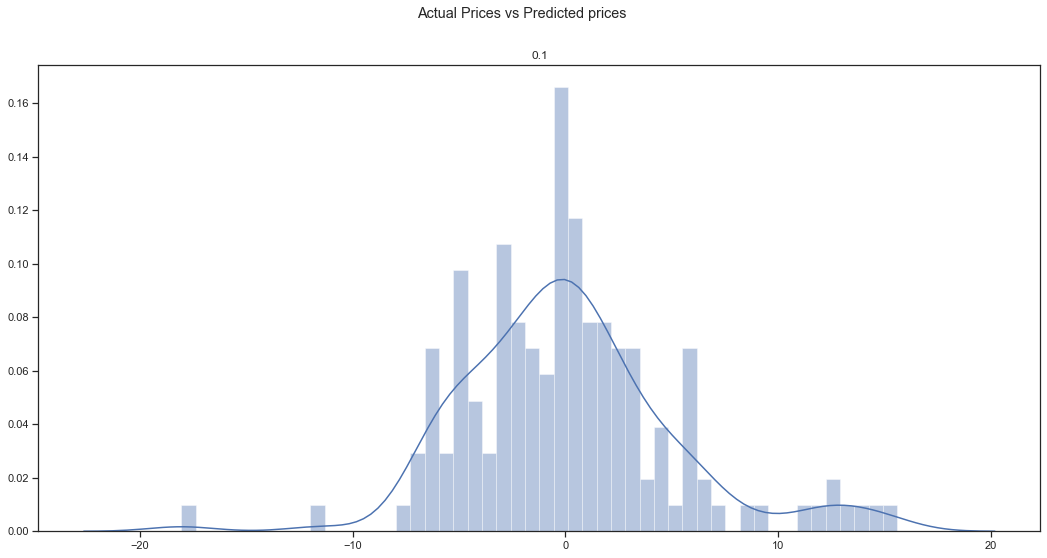

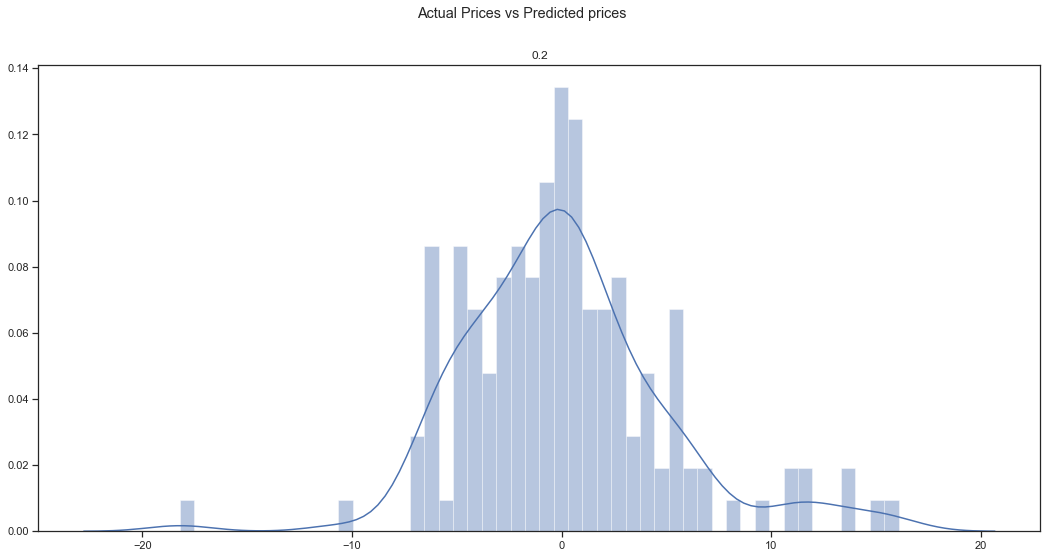

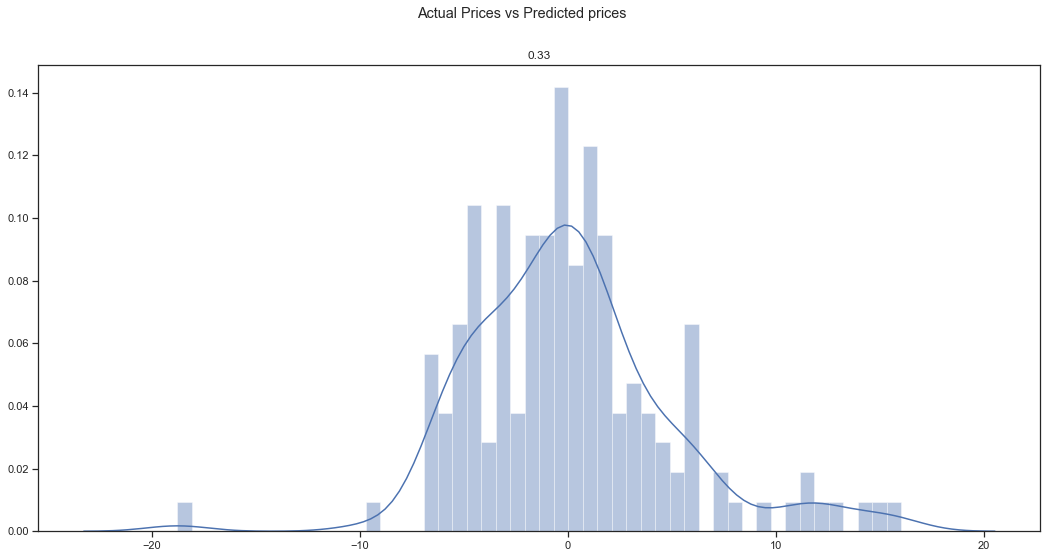

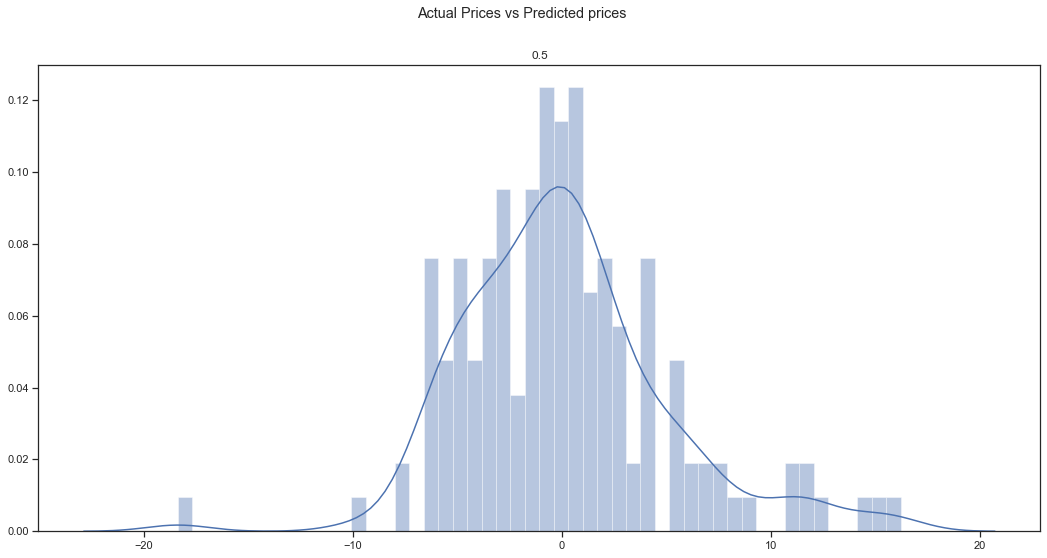

In [141]:
#1%, 5% 10%, 20%, 33%, and 50% 
temp_frame = imputation_defintion(.01)
res_frame = pd.concat([res_frame, temp_frame[0]])
temp_frame
res01 = temp_frame[1]
temp_frame = imputation_defintion(.05)
#temp_frame
res_frame = pd.concat([res_frame, temp_frame[0]])
res05 = temp_frame[1]
temp_frame = imputation_defintion(.1)
#temp_frame
res_frame = pd.concat([res_frame, temp_frame[0]])
res10 = temp_frame[1]
temp_frame = imputation_defintion(.2)
#temp_frame
res_frame = pd.concat([res_frame, temp_frame[0]])
res20 = temp_frame[1]
temp_frame = imputation_defintion(.33)
#temp_frame
res_frame = pd.concat([res_frame, temp_frame[0]])
res33 = temp_frame[1]
temp_frame = imputation_defintion(.5)
#temp_frame
res_frame = pd.concat([res_frame, temp_frame[0]])
res50 = temp_frame[1]
res_frame

In [142]:
res_frame

,Imputation %,imputation,mae,mse,rmse,R2,mae_diff,mse_diff,rmse_diff,R2_diff
0,0.00,none,3.604571,24.098505,4.909023,0.704940,NaN,NaN,NaN,NaN
0,0.01,MAR,3.611796,24.081772,4.907318,0.705145,0.007225,-0.016733,-0.001705,0.000205
0,0.05,MAR,3.658619,24.641265,4.963997,0.698294,0.054048,0.542761,0.054974,-0.006646
0,0.10,MAR,3.657249,24.979995,4.997999,0.694147,0.052677,0.881490,0.088976,-0.010793
0,0.20,MAR,3.557174,24.042646,4.903330,0.705624,-0.047397,-0.055858,-0.005693,0.000684
0,0.33,MAR,3.564066,24.041875,4.903251,0.705633,-0.040505,-0.056630,-0.005771,0.000693
0,0.50,MAR,3.619510,24.446555,4.944346,0.700678,0.014939,0.348050,0.035323,-0.004261


### Imputation Analysis: Round 2 - Missing at Random (version 2)


Step 3: Take two columns and create data “Missing at Random” when controlled for a third variable (i.e., if Variable Z is > 30, then Variables X, Y are randomly missing).  Use your preferred imputation method to fill in 10%, 20% and 30% of your missing data.

Question 3: In each case [10%, 20%, 30%] perform a fit with the imputed data and compare the loss and goodness of fit to your baseline.  [Note: you should have (9) models to compare against your baseline at this point.]


In [143]:
bostondf.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


This is also done in the python function, but to build the missing data we used AGE. AGE of greater than 77.5 will cause the function to build random missing data for variables RM and INDUS. Those are then imputed with median.

In [144]:
bostondfa = bostondf[bostondf['AGE'] > 77.5]
bostondfb = bostondf[bostondf['AGE'] <= 77.5]
bostondfa.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9
10,0.22489,12.5,7.87,0.0,0.524,6.377,94.3,6.3467,5.0,311.0,15.2,392.52,20.45,15.0


In [145]:
def imputation_defintion_two_variables(frac):
    
#	CRIM	ZN	INDUS	CHAS	NOX	RM	AGE	DIS	RAD	TAX	PTRATIO	B	LSTAT	MEDV
#0	0.00632	18.0	2.31	0.0	0.538	6.575	65.2	4.0900	1.0	296.0	15.3	396.90	4.98	24.0
#1	0.02731	0.0	7.07	0.0	0.469	6.421	78.9	4.9671	2.0	242.0	17.8	396.90	9.14	21.6
#2	0.02729	0.0	7.07	0.0	0.469	7.185	61.1	4.9671	2.0	242.0	17.8	392.83	4.03	34.7
#3	0.03237	0.0	2.18	0.0	0.458	6.998	45.8	6.0622	3.0	222.0	18.7	394.63	2.94	33.4
#4	0.06905	0.0	2.18	0.0	0.458	7.147	54.2	6.0622	3.0	222.0	18.7	396.90	5.33	36.2    
#    :Attribute Information (in order):
#        - CRIM     per capita crime rate by town
#        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
#        - INDUS    proportion of non-retail business acres per town
#        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
#        - NOX      nitric oxides concentration (parts per 10 million)
#        - RM       average number of rooms per dwelling
#        - AGE      proportion of owner-occupied units built prior to 1940
#        - DIS      weighted distances to five Boston employment centres
#        - RAD      index of accessibility to radial highways
#        - TAX      full-value property-tax rate per $10,000
#        - PTRATIO  pupil-teacher ratio by town
#        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
#        - LSTAT    % lower status of the population
#        - MEDV     Median value of owner-occupied homes in $1000's

#get two dataframes one with age over 77.5 one with less.
    bostondfa = bostondf[bostondf['AGE'] > 77.5]
    bostondfb = bostondf[bostondf['AGE'] <= 77.5]


#**Here we can randomly sample the over 77.5 dataset and replace a single column's values**  
    in_sample = bostondfa.sample(frac=frac, random_state=99)
    in_sample.shape
    out_sample = bostondfa[~bostondfa.isin(in_sample)].dropna()
    out_sample.shape

    print(out_sample.shape[0] + in_sample.shape[0])
    print(bostondf.shape[0])

    in_sample.head()

 ## Choose variables to replace   
    #in_sample['NOX'] = np.nan
    in_sample['RM'] = np.nan
    in_sample['INDUS'] = np.nan
    in_sample.head()

    #out_sample['NOX'].median()
    out_sample['RM'].median()
    out_sample['INDUS'].median()

    #in_sample['NOX'] = in_sample['NOX'].fillna(out_sample['NOX'].median())
    #in_sample['NOX'] = in_sample['NOX'].fillna(1)
 #**Choose an imputation method**   
    in_sample['RM'] = in_sample['RM'].fillna(out_sample['RM'].median())
    in_sample['INDUS'] = in_sample['INDUS'].fillna(out_sample['INDUS'].median())
    in_sample.head()
#**Rejoin the imputed and original datasets**
    frames = [in_sample, out_sample, bostondfb]
    imputed_data = pd.concat(frames)
    imputed_data = imputed_data.sort_index()
    imputed_data.head()

#**Use the same training and testing indices to fit the model**    
    train_set = imputed_data.iloc[train_index]
    test_set = imputed_data.iloc[test_index]
    train_set.head()
    
    X_train = train_set.iloc[:, :-1].values
    Y_train = train_set.iloc[:, -1].values
    X_test = test_set.iloc[:, :-1].values
    Y_test = test_set.iloc[:, -1].values

#**Fit a new model to the imputed dataset**
    reg2 = LinearRegression().fit(X_train, Y_train)
    print(reg2.score(X_train, Y_train))
    print(reg2.coef_)
    print(reg2.intercept_)
    print(reg2.get_params())

    Y_pred = reg2.predict(X_test)

    mae = mean_absolute_error(Y_test,Y_pred)
    mse = mean_squared_error(Y_test,Y_pred)
    rmse_val = rmse(Y_test,Y_pred)
    r2 = r2_score(Y_test,Y_pred)
    print("MAE: %.3f"%mae)
    print("MSE:  %.3f"%mse)
    print("RMSE:  %.3f"%rmse_val)
    print("R2:  %.3f"%r2)
    plt.figure(figsize = (16,8))
    plt.title(frac)
    plt.suptitle("Actual Prices vs Predicted prices")
    sns.distplot((Y_test-Y_pred),bins=50);
    
    temp_frame = pd.DataFrame({'Imputation %':frac,
                   'imputation':'MAR2V',
                   'mae': mae, 
                   'mse': mse, 
                   'rmse':rmse_val,
                   'R2':r2,
                   'mae_diff':mae-orig_mae,
                   'mse_diff':mse-orig_mse,
                   'rmse_diff':rmse_val-orig_rmse_val,
                   'R2_diff':r2-orig_r2
                   }, index=[0])
    return temp_frame, Y_test-Y_pred

253
506
0.7507240573328869
[-1.32417022e-01  5.23899558e-02  2.57703675e-02  3.49910039e+00
 -1.91777985e+01  4.07589307e+00  1.52278394e-02 -1.49481944e+00
  2.91605651e-01 -9.50004366e-03 -9.56156925e-01  6.35203636e-03
 -5.83636136e-01]
35.380485525751034
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
MAE: 3.579
MSE:  23.929
RMSE:  4.892
R2:  0.707


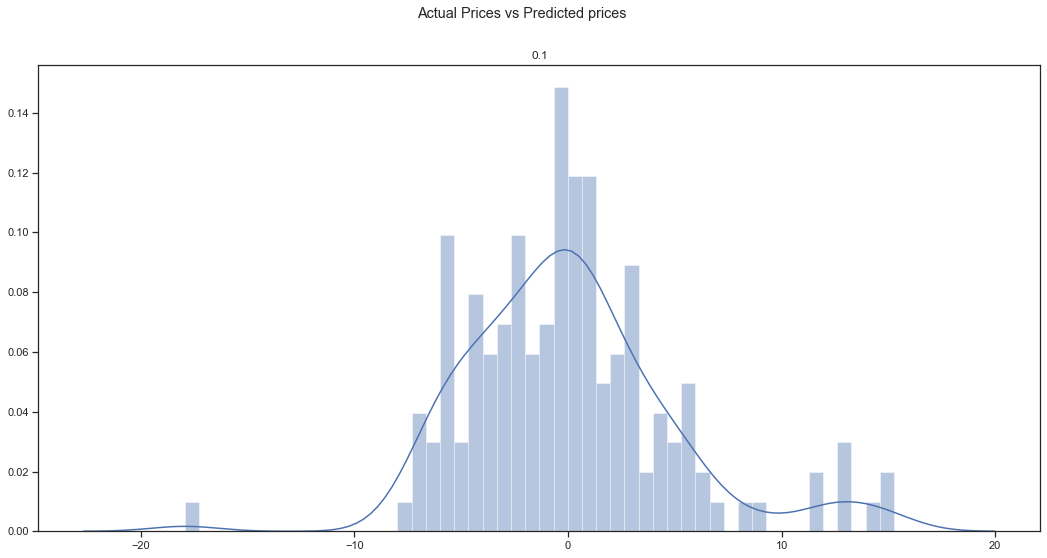

In [146]:
#10%, 20%, 30%
temp_frame2 = imputation_defintion_two_variables(.1)
temp_frame2
res_frame2 =temp_frame2[0]
#res_frame2
res210 = temp_frame[1]

253
506
0.7453145516995417
[-1.32842145e-01  5.34954113e-02  1.55581248e-02  3.57849676e+00
 -1.99229250e+01  3.81584780e+00  1.81989587e-02 -1.52934268e+00
  2.99103763e-01 -9.50688639e-03 -9.54804537e-01  6.00593413e-03
 -6.10887064e-01]
37.80168074837839
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
MAE: 3.551
MSE:  23.620
RMSE:  4.860
R2:  0.711
253
506
0.7396696681696734
[-1.33527752e-01  5.49163040e-02  3.87108178e-02  3.84887613e+00
 -2.01661966e+01  3.63983437e+00  2.03874495e-02 -1.52780556e+00
  3.17996013e-01 -1.03823502e-02 -9.89256666e-01  5.74078137e-03
 -6.41861912e-01]
39.91537213266819
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
MAE: 3.542
MSE:  22.701
RMSE:  4.765
R2:  0.722


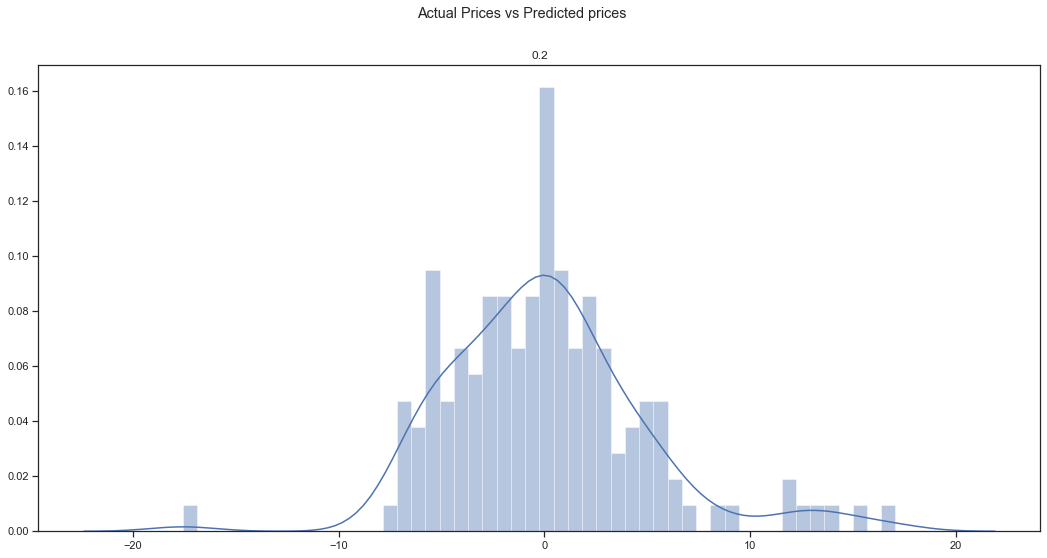

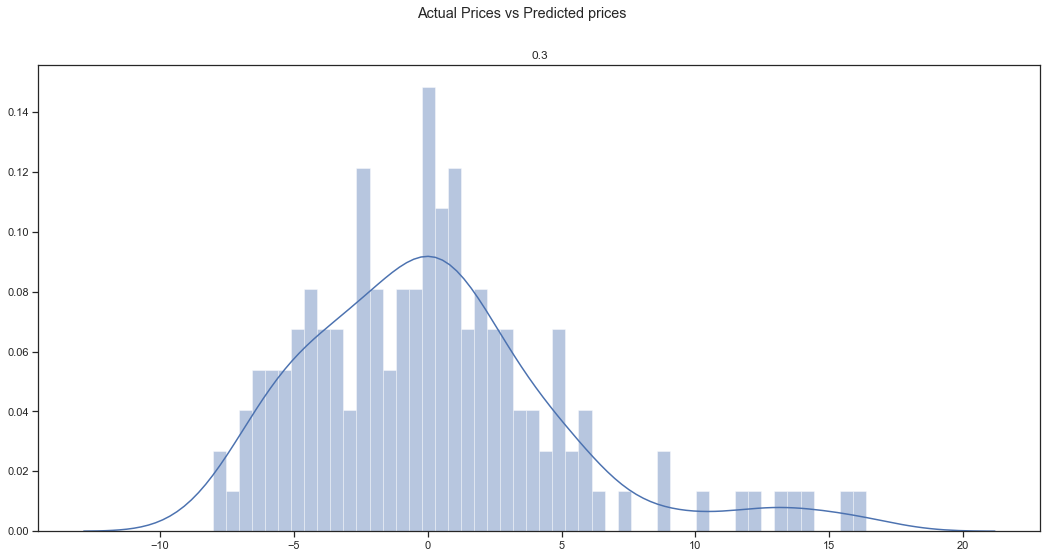

In [147]:
temp_frame2 = imputation_defintion_two_variables(.2)
temp_frame2
res_frame2 = pd.concat([res_frame2, temp_frame2[0]])
res220 = temp_frame[1]

temp_frame2 = imputation_defintion_two_variables(.3)
temp_frame2
res_frame2 = pd.concat([res_frame2, temp_frame2[0]])
res230 = temp_frame[1]

In [148]:
res_frame2
res_frame = pd.concat([res_frame, res_frame2])

In [149]:
res_frame

,Imputation %,imputation,mae,mse,rmse,R2,mae_diff,mse_diff,rmse_diff,R2_diff
0,0.00,none,3.604571,24.098505,4.909023,0.704940,NaN,NaN,NaN,NaN
0,0.01,MAR,3.611796,24.081772,4.907318,0.705145,0.007225,-0.016733,-0.001705,0.000205
0,0.05,MAR,3.658619,24.641265,4.963997,0.698294,0.054048,0.542761,0.054974,-0.006646
0,0.10,MAR,3.657249,24.979995,4.997999,0.694147,0.052677,0.881490,0.088976,-0.010793
0,0.20,MAR,3.557174,24.042646,4.903330,0.705624,-0.047397,-0.055858,-0.005693,0.000684
0,0.33,MAR,3.564066,24.041875,4.903251,0.705633,-0.040505,-0.056630,-0.005771,0.000693
0,0.50,MAR,3.619510,24.446555,4.944346,0.700678,0.014939,0.348050,0.035323,-0.004261
0,0.10,MAR2V,3.578703,23.929496,4.891778,0.707009,-0.025868,-0.169009,-0.017244,0.002069
0,0.20,MAR2V,3.551250,23.620080,4.860049,0.710798,-0.053322,-0.478425,-0.048973,0.005858
0,0.30,MAR2V,3.541983,22.701046,4.764562,0.722050,-0.062588,-1.397458,-0.144461,0.017110


### Imputation Analysis: Round 3 - Missing Not at Random


Step 4:  Create a “Missing Not at Random” pattern in which 25% of the data is missing for a single column.

Question 4: Perform a fit with the imputed data [25%] and compare the loss and goodness of fit to your baseline.  [Note: you should have (10) models to compare against your baseline at this point.]

**Missing Not at Random (MNAR)** probability of missing values, not at random, depends on information that has not been recorded, and this information predicts the missing values, almost impossible to handle - shouldn't be any effect of MNAR on inferences made by a model trained on such data.


In [150]:
def imputation_defintion_nar(frac):
#**Here we can randomly sample the full dataset and replace a single column's values**  
    numrows = len(bostondf)
    numrows
    twentyfivepercent = round(numrows * frac)
    twentyfivepercent
    in_sample = bostondfb.iloc[twentyfivepercent:]
    in_sample.shape
    out_sample = bostondf[~bostondf.isin(in_sample)].dropna()
    out_sample.shape

    print(out_sample.shape[0] + in_sample.shape[0])
    print(bostondf.shape[0])

    in_sample.head()

 ## Choose a variable to replace   
    in_sample['NOX'] = np.nan
    #in_sample['RM'] = np.nan
    in_sample.head()

    out_sample['NOX'].median()
    #out_sample['RM'].median()

    #in_sample['NOX'] = in_sample['NOX'].fillna(out_sample['NOX'].median())
    #in_sample['NOX'] = in_sample['NOX'].fillna(1)
 #**Choose an imputation method**   
    #in_sample['RM'] = in_sample['RM'].fillna(out_sample['RM'].median())
    in_sample['NOX'] = in_sample['NOX'].fillna(out_sample['NOX'].median())
    in_sample.head()
#**Rejoin the imputed and original datasets**
    imputed_data = pd.concat([in_sample, out_sample])
    imputed_data = imputed_data.sort_index()
    imputed_data.head()

#**Use the same training and testing indices to fit the model**    
    train_set = imputed_data.iloc[train_index]
    test_set = imputed_data.iloc[test_index]
    train_set.head()
    
    X_train = train_set.iloc[:, :-1].values
    Y_train = train_set.iloc[:, -1].values
    X_test = test_set.iloc[:, :-1].values
    Y_test = test_set.iloc[:, -1].values

#**Fit a new model to the imputed dataset**
    reg2 = LinearRegression().fit(X_train, Y_train)
    print(reg2.score(X_train, Y_train))
    print(reg2.coef_)
    print(reg2.intercept_)
    print(reg2.get_params())

    Y_pred = reg2.predict(X_test)

    mae = mean_absolute_error(Y_test,Y_pred)
    mse = mean_squared_error(Y_test,Y_pred)
    rmse_val = rmse(Y_test,Y_pred)
    r2 = r2_score(Y_test,Y_pred)
    print("MAE: %.3f"%mae)
    print("MSE:  %.3f"%mse)
    print("RMSE:  %.3f"%rmse_val)
    print("R2:  %.3f"%r2)

    plt.figure(figsize = (16,8))
    plt.title(frac)
    plt.suptitle("Actual Prices vs Predicted prices")
    sns.distplot((Y_test-Y_pred),bins=50);
    
    temp_frame = pd.DataFrame({'Imputation %':frac,
                   'imputation':'NAR',
                   'mae': mae, 
                   'mse': mse, 
                   'rmse':rmse_val,
                   'R2':r2,
                   'mae_diff':mae-orig_mae,
                   'mse_diff':mse-orig_mse,
                   'rmse_diff':rmse_val-orig_rmse_val,
                   'R2_diff':r2-orig_r2
                   }, index=[0])
    return temp_frame, Y_test-Y_pred

In [151]:
numrows = len(bostondf)
numrows
twentyfivepercent = round(numrows * .25)
twentyfivepercent

126

506
506
0.7464238757815275
[-1.26118957e-01  5.67664057e-02  5.21905891e-02  3.66929679e+00
 -1.65432173e+01  3.93903584e+00  9.88054774e-03 -1.21482275e+00
  2.87958847e-01 -9.97283815e-03 -9.28021921e-01  6.78056752e-03
 -5.86552817e-01]
33.514097065968286
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
MAE: 3.548
MSE:  24.029
RMSE:  4.902
R2:  0.706


C:\ProgramData\Anaconda3\envs\ML7331\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\envs\ML7331\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


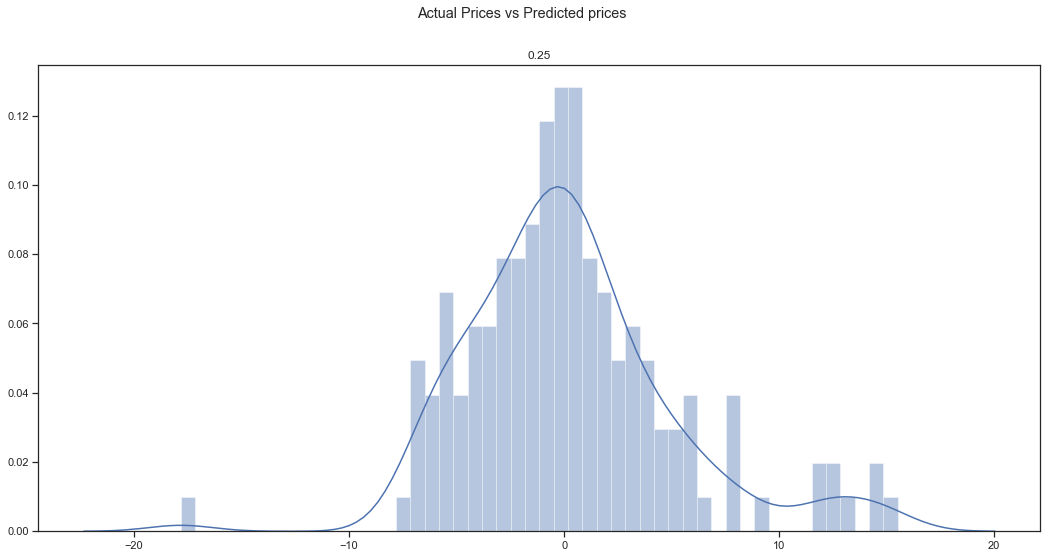

In [152]:
temp_frame3 = imputation_defintion_nar(.25)
temp_frame3
resnar = temp_frame3[1]

## Conclusion

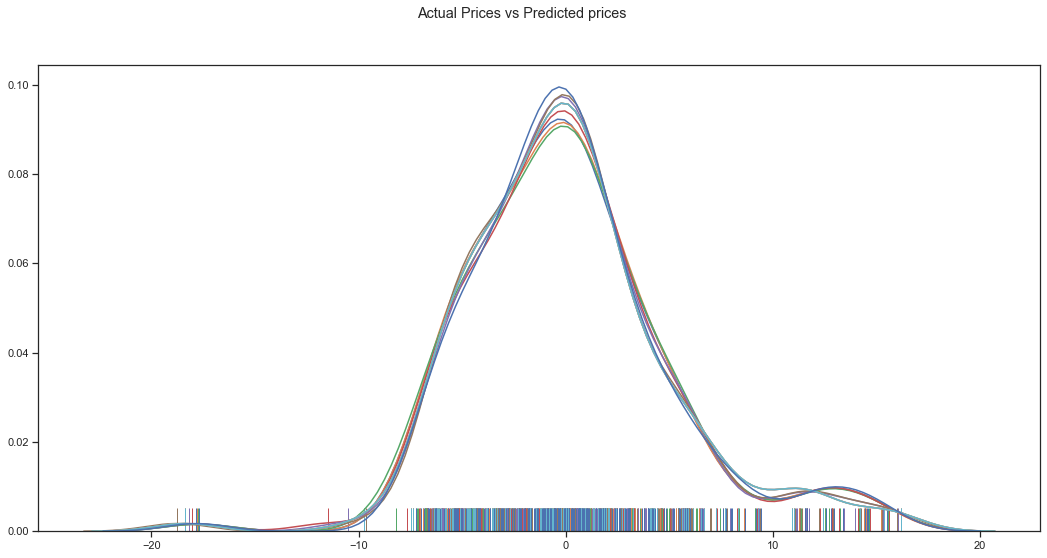

In [160]:
plt.figure(figsize = (16,8))
plt.suptitle("Actual Prices vs Predicted prices")
sns.distplot((res0),bins=50, hist=False, rug=True);
sns.distplot((res01),bins=50, hist=False, rug=True); 
sns.distplot((res05),bins=50, hist=False, rug=True); 
sns.distplot((res10),bins=50, hist=False, rug=True); 
sns.distplot((res20),bins=50, hist=False, rug=True); 
sns.distplot((res33),bins=50, hist=False, rug=True); 
sns.distplot((res50),bins=50, hist=False, rug=True); 
sns.distplot((res210),bins=50, hist=False, rug=True);
sns.distplot((res220),bins=50, hist=False, rug=True);
sns.distplot((res230),bins=50, hist=False, rug=True);
sns.distplot((resnar),bins=50, hist=False, rug=True);
plt.show()

Step 5: Describe your imputation approach and summarize your findings.  What impact did the missing data have on your baseline model’s performance? 

In [161]:
res_frame = pd.concat([res_frame, temp_frame3[0]])
res_frame 

,Imputation %,imputation,mae,mse,rmse,R2,mae_diff,mse_diff,rmse_diff,R2_diff
0,0.00,none,3.604571,24.098505,4.909023,0.704940,NaN,NaN,NaN,NaN
0,0.01,MAR,3.611796,24.081772,4.907318,0.705145,0.007225,-0.016733,-0.001705,0.000205
0,0.05,MAR,3.658619,24.641265,4.963997,0.698294,0.054048,0.542761,0.054974,-0.006646
0,0.10,MAR,3.657249,24.979995,4.997999,0.694147,0.052677,0.881490,0.088976,-0.010793
0,0.20,MAR,3.557174,24.042646,4.903330,0.705624,-0.047397,-0.055858,-0.005693,0.000684
0,0.33,MAR,3.564066,24.041875,4.903251,0.705633,-0.040505,-0.056630,-0.005771,0.000693
0,0.50,MAR,3.619510,24.446555,4.944346,0.700678,0.014939,0.348050,0.035323,-0.004261
0,0.10,MAR2V,3.578703,23.929496,4.891778,0.707009,-0.025868,-0.169009,-0.017244,0.002069
0,0.20,MAR2V,3.551250,23.620080,4.860049,0.710798,-0.053322,-0.478425,-0.048973,0.005858
0,0.30,MAR2V,3.541983,22.701046,4.764562,0.722050,-0.062588,-1.397458,-0.144461,0.017110


## References

- https://medium.com/towards-artificial-intelligence/handling-missing-data-for-advanced-machine-learning-b6eb89050357

- https://towardsdatascience.com/things-you-didnt-know-about-the-boston-housing-dataset-2e87a6f960e8

- https://www.kellogg.northwestern.edu/faculty/weber/jhu/statistics/boston.htm



“Working with Missing Data”

Step 1:
Use sklearn.datasets to get the Boston Housing dataset.
Fit a linear regressor to the data as a baseline.  There is no need to do Cross-Validation.  We will simply be exploring the change in results.

Question 1: What is the loss and what are the goodness of fit parameters?  This will be our baseline for comparison.

Step 2: (repeat for each percentage value below)
Select 1%, 5% 10%, 20%, 33%, and 50% of your data in a single column [hold that column selection constant throughout all iterations] (Completely at random), replace the original value with a NaN (i.e., “not a number” – ex., np.nan) and then perform an imputation for the missing values.   

Question 2: In each case [1%, 5%, 10%, 20%, 33%, 50%] perform a fit with the imputed data and compare the loss and goodness of fit to your baseline.  [Note: you should have (6) models to compare against your baseline at this point.]

Step 3: Take two columns and create data “Missing at Random” when controlled for a third variable (i.e., if Variable Z is > 30, then Variables X, Y are randomly missing).  Use your preferred imputation method to fill in 10%, 20% and 30% of your missing data.

Question 3: In each case [10%, 20%, 30%] perform a fit with the imputed data and compare the loss and goodness of fit to your baseline.  [Note: you should have (9) models to compare against your baseline at this point.]


Step 4:  Create a “Missing Not at Random” pattern in which 25% of the data is missing for a single column.

Question 4: Perform a fit with the imputed data [25%] and compare the loss and goodness of fit to your baseline.  [Note: you should have (10) models to compare against your baseline at this point.]

Step 5: Describe your imputation approach and summarize your findings.  What impact did the missing data have on your baseline model’s performance? 
